In [22]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F



def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )



class BasicBlock(nn.Module):


    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )
        # shortcut
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


class BottleNeck(nn.Module):

    expansion = 2

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


class DICNet(nn.Module):

    def __init__(self, in_channel, out_channel, block, num_block):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv1_x = self._make_layer(block, 64, num_block[5], 2)

        self.conv2_x = self._make_layer(block, 128, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 256, num_block[3], 2)
        self.conv6_x = self._make_layer(block, 512, num_block[4], 2)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up4 = double_conv(1024 + 512, 512)
        self.dconv_up3 = double_conv(512 + 512, 256)
        self.dconv_up2 = double_conv(256 + 256, 128)
        self.dconv_up1 = double_conv(128 + 256, 64)

        self.dconv_last = nn.Sequential(
            nn.Conv2d(64+64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # nn.Upsample(scale_factor=2, mode='bicubic', align_corners=True),
            nn.Conv2d(64, out_channel, 1)
        )

    def _make_layer(self, block, out_channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        conv1 = self.conv1(x)  # [batch_size, 64, 128, 128]
        temp = self.conv1_x(conv1)  # [batch_size, 128, 64, 64]
        conv2 = self.conv2_x(temp)  # 2[batch_size, 256, 64, 64]
        conv3 =self.conv3_x(conv2)  # 2[batch_size, 256, 32, 32]
        conv4 = self.conv4_x(conv3) # 2[batch_size, 512, 16, 16]
        conv5 = self.conv5_x(conv4) # 2[batch_size, 512, 8, 8]
        bottle = self.conv6_x(conv5) # 2[batch_size, 1024, 4, 4]

        x = self.upsample(bottle) # [batch_size, 1024, 8, 8]

        x = torch.cat([x, conv5], dim=1) # [batch_size, 1024+512, 8, 8]

        x = self.dconv_up4(x) # [batch_size, 512, 8, 8]
        x = self.upsample(x) # [batch_size, 512, 16, 16]

        x = torch.cat([x, conv4], dim=1) # [batch_size, 512 + 512, 16, 16]

        x = self.dconv_up3(x)  # [batch_size, 256, 16, 16]
        x = self.upsample(x)  # [batch_size, 256, 32, 32]

        x = torch.cat([x, conv3], dim=1)  # [batch_size, 256 + 256, 32, 32]

        x = self.dconv_up2(x) # [batch_size, 128, 32, 32]
        x = self.upsample(x) # [batch_size, 128, 64, 64]

        x = torch.cat([x, conv2], dim=1) # [batch_size, 128+256, 64, 64]

        x = self.dconv_up1(x) # [batch_size, 64, 64, 64]
        x = self.upsample(x) # [batch_size, 64, 128, 128]

        x = torch.cat([x, conv1], dim=1) # [batch_size, 64+64, 128, 128]
        out = self.dconv_last(x) # [batch_size, 2, 128, 128]
        return out


def DICNet_s(in_channel,out_channel):

    model = DICNet(in_channel,out_channel,BottleNeck, [5, 6, 8, 5, 3, 1])

    return model

For the code in the next block
* You could select device to be "cpu" or "cuda"
* You must change the path of the ck load file to your model parameter file storage directory

In [24]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
ck = torch.load('H:\\Deep-DIC\\DIC-Net-s\\model_best.pth.tar')# file path of model parameters

model = DICNet_s(2, 3).to(device)
model.load_state_dict(ck['state_dict'])

<All keys matched successfully>

For the code in the next block
* You must change the path1 and path2 to your image file
* the oder of Ref and Def must be right
* the Ref should be [:, 1, :, :]
* the Def should be [:, 0, :, :]

In [18]:
import torch
import math
import numpy as np
from PIL import Image
import os
from skimage import io

path1 = 'G:\\star6\\star6_image\\Star6ref.bmp'#file path of reference image
path2 = 'G:\\star6\\star6_image\\Star6def.bmp'#file path of deformed image
path3 = 'G:\\star6\\star6_image\\Star6noise.bmp'#file path of deformed image


def speckle_pair(path1, path2, reverse = 0):
    
    Ref = Image.open(path1)
    Def = Image.open(path2)
     

    Ref = np.array(Ref)
    Def = np.array(Def)

    image_h, image_w = Ref.shape
    image_h_new, image_w_new = (math.ceil(image_h/32)*32, math.ceil(image_w/32)*32)

    Ref_new = np.zeros((image_h_new, image_w_new))
    Def_new = np.zeros((image_h_new, image_w_new))

    Ref_new[:image_h,:image_w] = Ref
    Def_new[:image_h,:image_w] = Def
    speckle_pair = np.zeros((2, image_h_new, image_w_new)) 
    
    if reverse == 1:
        speckle_pair[0, :, :] = Ref_new
        speckle_pair[1, :, :] = Def_new
    else:
        speckle_pair[1, :, :] = Ref_new
        speckle_pair[0, :, :] = Def_new
        
    speckle_pair = torch.unsqueeze(torch.from_numpy(speckle_pair), 0).float()

    return speckle_pair, image_h, image_w

speckle_pair,image_h, image_w= speckle_pair(path1, path2, reverse = 0)
speckle_pair.shape,image_h, image_w

(torch.Size([1, 2, 512, 4000]), 501, 4000)

In [19]:
device = torch.device('cpu')
Ref_Def = speckle_pair.to('cpu')
with torch.no_grad():
    model.eval()
    output = model(Ref_Def)
output = output.cpu().numpy()

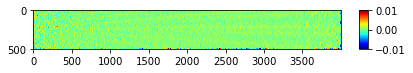

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

def DIC_Net_show(output,image_h, image_w, axis = 'ux'):
    ux = np.zeros((image_h, image_w))
    vy = np.zeros((image_h, image_w))
    rxy = np.zeros((image_h, image_w))
    ux[:,:] = output[0,0,:image_h,:image_w]
    vy[:,:] = output[0,1,:image_h,:image_w]
    rxy[:,:] = output[0,2,:image_h,:image_w]
    if axis == 'ux':
        show_this = ux
    elif axis == 'vy':
        show_this = vy
    elif axis == 'rxy':
        show_this = rxy
    ax = plt.subplot()
    im = ax.imshow(show_this, vmin=-0.01, vmax=0.01, cmap='jet')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.25)
    plt.colorbar(im, cax=cax)
    
DIC_Net_show(output,image_h, image_w,axis = 'ux')

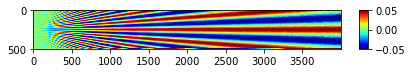

In [21]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

def DIC_Net_show(output,image_h, image_w, axis = 'ux'):
    ux = np.zeros((image_h, image_w))
    vy = np.zeros((image_h, image_w))
    rxy = np.zeros((image_h, image_w))
    ux[:,:] = output[0,0,:image_h,:image_w]
    vy[:,:] = output[0,1,:image_h,:image_w]
    rxy[:,:] = output[0,2,:image_h,:image_w]
    if axis == 'ux':
        show_this = ux
    elif axis == 'vy':
        show_this = vy
    elif axis == 'rxy':
        show_this = rxy
    ax = plt.subplot()
    im = ax.imshow(show_this, vmin=-0.05, vmax=0.05, cmap='jet')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.25)
    plt.colorbar(im, cax=cax)
    
DIC_Net_show(output,image_h, image_w,axis = 'vy')